# Visualization
This notebook contains a simple cell to plot the output of a pretrained eqt model

In [1]:
import numpy as np
import torch


import seisbench.generate as sbg
from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer

import swag

import matplotlib.pyplot as plt

from utils import *


In [2]:
# Load saved model.
swag_model = swag.posteriors.SWAG(
    EQTransformer,
    no_cov_mat=True,
    max_num_models=20,
    in_channels=1,
)
model = EQTransformer(in_channels=1)

checkpoint = torch.load("first swag run/checkpoint-20.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

In [3]:
# Load data.
data = WaveformDataset("data/STEAD/example/seisbench")
train_loader, dev_loader, _ = preprocess(data, batch_size=100, num_workers=0)


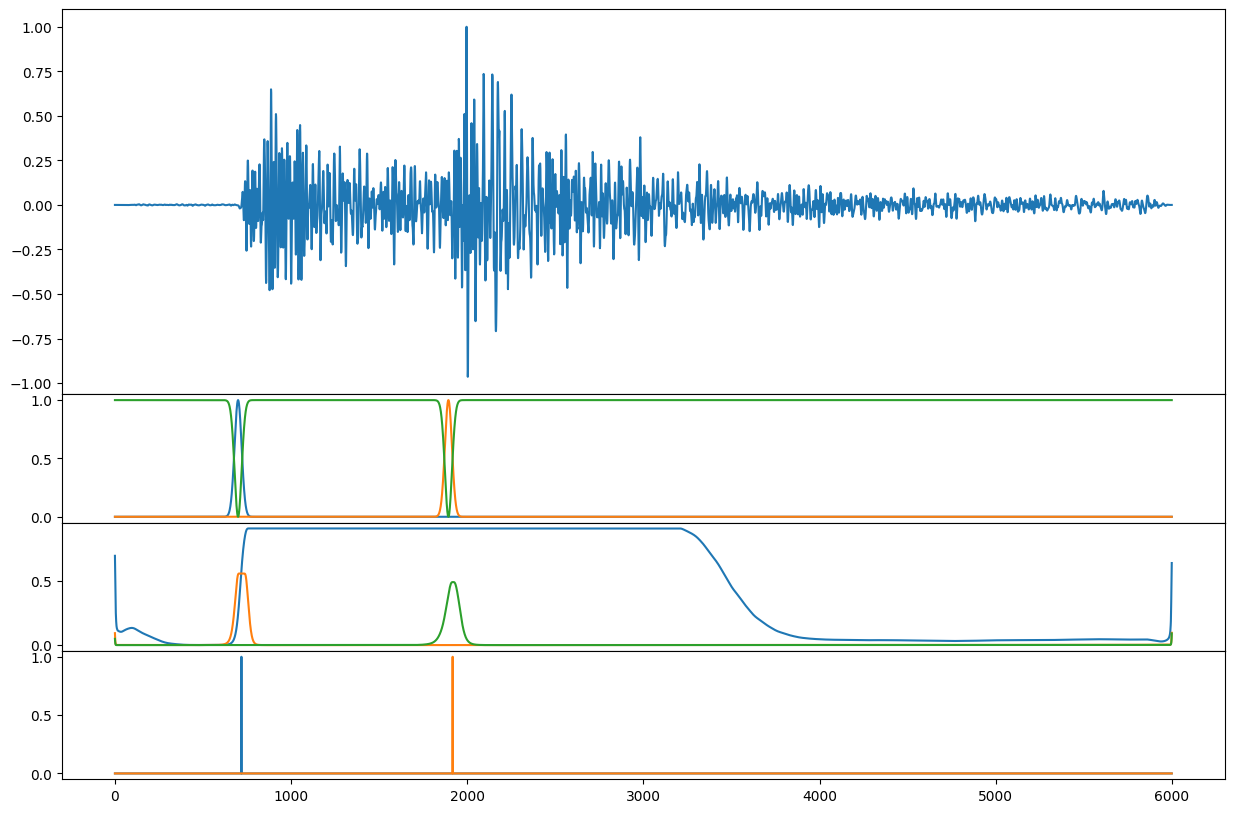

In [4]:
sample = dev_loader.dataset[0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    det_pred, p_pred, s_pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = torch.cat((det_pred, p_pred, s_pred)).cpu().numpy()

    score_detection = torch.zeros(det_pred.shape[0])
    score_p_or_s = torch.zeros(det_pred.shape[0])
    p_sample = torch.zeros(det_pred.shape[0], dtype=int)
    s_sample = torch.zeros(det_pred.shape[0], dtype=int)

    for i in range(det_pred.shape[0]):
        # TODO In pick-benchmark every batch as a "window_borders" property that is used here, but we do not have that (?) so I am just using the full rage instead.
        # start_sample, end_sample = window_borders[i]
        local_det_pred = det_pred[i, :]
        local_p_pred = p_pred[i, :]
        local_s_pred = s_pred[i, :]

        score_detection[i] = torch.max(local_det_pred)
        score_p_or_s[i] = torch.max(local_p_pred) / torch.max(
            local_s_pred
        )  # most likely P by most likely S

        p_sample[i] = torch.argmax(local_p_pred)
        s_sample[i] = torch.argmax(local_s_pred)

    p_loc = torch.zeros(det_pred.shape[1], dtype=int)
    p_loc[p_sample[0]] = 1

    s_loc = torch.zeros(det_pred.shape[1], dtype=int)
    s_loc[s_sample[0]] = 1

axs[2].plot(pred.T)
axs[3].plot(torch.stack((p_loc, s_loc), dim=0).T)
